# MODELO AUTO REGRESIVO INTEGRADO EN MEDIAS MÓVILES (ARIMA)
En este documento se presenta un ejemplo de estimación de un modelo econométrico de series temporales.

En primer lugar se descargan un conjunto de librerías necesarias para correr los modelos.

In [1]:
# pandas, pandas_datareader, numpy and matplotlib
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
import yfinance as yf
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# ARIMA
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import pmdarima as pm

Se utilizarán datos obtenidos de https://finance.yahoo.com/, en este caso se descargan datos de una criptomoneda, sin embargo, se pueden descargar datos de monedas (EURUSD=X) u otros activos financieros.

In [2]:
RISKY_ASSET = ['ETH-USD']
START_DATE = '2017-01-01'
END_DATE = '2022-06-10'

In [3]:
df = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

[*********************100%***********************]  1 of 1 completed


A continuación, se utilizan los precios de cierre para calcular los rendimientos diarios.

In [4]:
returns = df['Adj Close'].pct_change().dropna()
returns.name = 'asset_returns'

En la siguiente gráfica, se presentan los rendimientos diarios.

<AxesSubplot:title={'center':"['ETH-USD'] returns: 2017-01-01 - 2022-06-10"}, xlabel='Date'>

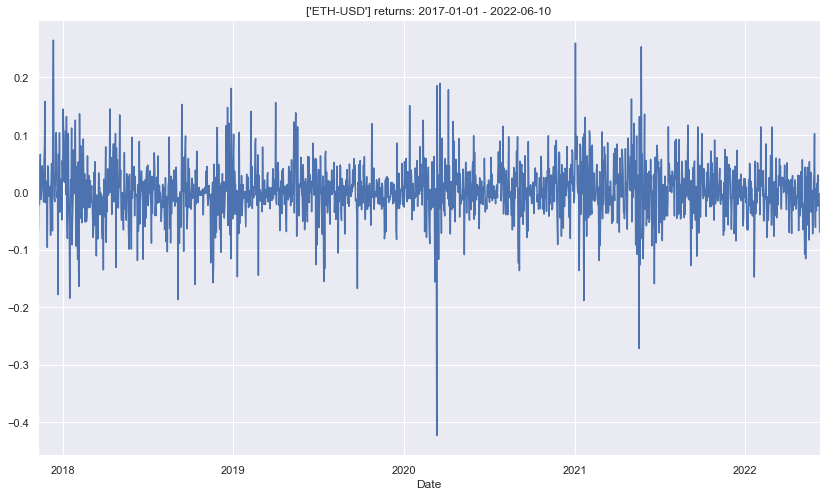

In [5]:
plt.figure(figsize=(14,8))
returns.plot(title=f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}')

Es necesario evaluar si las series temporales son estacionarias en covarianza, para esto a continuación, se implementa el augmented Dickey–Fuller test (ADF) y el Kwiatkowski–Phillips–Schmidt–Shin test (KPSS).

In [6]:
def adf_test(x):
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
        return results

In [7]:
adf_test(returns)

Test Statistic           -1.491750e+01
p-value                   1.427904e-27
# of Lags Used            5.000000e+00
# of Observations Used    1.668000e+03
Critical Value (1%)      -3.434276e+00
dtype: float64

In [8]:
def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
        return results

In [9]:
kpss_test(returns)

C:\Users\ALEJANDRO VARGAS\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\ALEJANDRO VARGAS\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic           0.170788
p-value                  0.100000
# of Lags               25.000000
Critical Value (10%)     0.347000
dtype: float64

Para conocer las características de la serie de tiempo, se presenta los diagramas de Autocorrelación (AC) y Autocorrelación Parcial (PAC) con 40 rezagos.

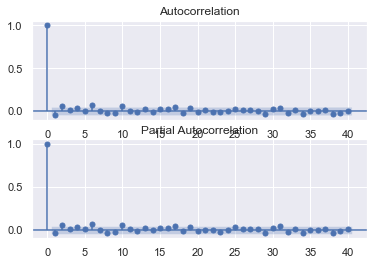

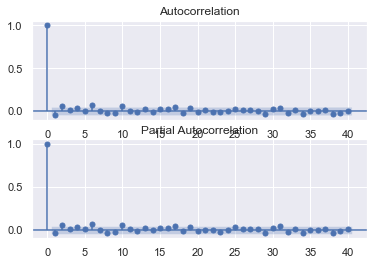

In [10]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(returns, ax=ax[0], lags=N_LAGS,
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(returns, ax=ax[1], lags=N_LAGS,
          alpha=SIGNIFICANCE_LEVEL)

A continuación, se formula un modelo ARIMA con dos rezagos en el componente autorregresivo y un rezago en el componente de medias móviles.

In [11]:
arima = ARIMA(returns, order=(2, 0, 1)).fit(disp=0)
arima.summary()

C:\Users\ALEJANDRO VARGAS\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\ALEJANDRO VARGAS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so in

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          asset_returns   No. Observations:                 1674
Model:                     ARMA(2, 1)   Log Likelihood                2614.632
Method:                       css-mle   S.D. of innovations              0.051
Date:                Mon, 13 Jun 2022   AIC                          -5219.265
Time:                        10:18:26   BIC                          -5192.150
Sample:                    11-10-2017   HQIC                         -5209.219
                         - 06-10-2022                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0023      0.001      1.602      0.109      -0.001       0.005
ar.L1.asset_returns     0.7308      0.257      2.844      0.004       0.227       1.234
ar.L2.asset_returns     0.0750      0.026      2.854      0.004       0.024       0.127
ma.L1.asset_returns    -0.7752      0.258     -3.007      0.003      -1.281      -0.270
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2165           +0.0000j            1.2165            0.0000
AR.2          -10.9575           +0.0000j           10.9575            0.5000
MA.1            1.2900           +0.0000j            1.2900            0.0000
-----------------------------------------------------------------------------
"""

Se desarrolla un diagnóstico de los resíduos del modelo: Normalidad y Autocorrelación.

In [12]:
def arima_diagnostics(resids, n_lags=40):
    # create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')
    
    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.distplot(resids_nonmissing, hist=True, kde=True,
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()

    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')
    
    return fig

C:\Users\ALEJANDRO VARGAS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ALEJANDRO VARGAS\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


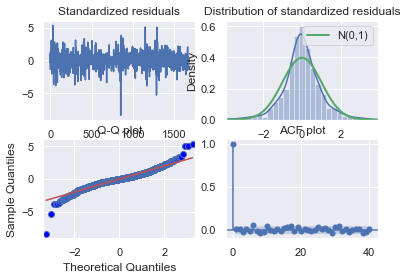

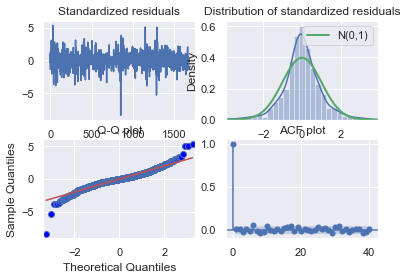

In [13]:
arima_diagnostics(arima.resid, 40)

También se implemente el test de autocorrelación de Ljung–Box test.

C:\Users\ALEJANDRO VARGAS\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
C:\Users\ALEJANDRO VARGAS\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, "Ljung-Box test's results"),
 Text(0.5, 0, 'Lag'),
 Text(0, 0.5, 'p-value')]

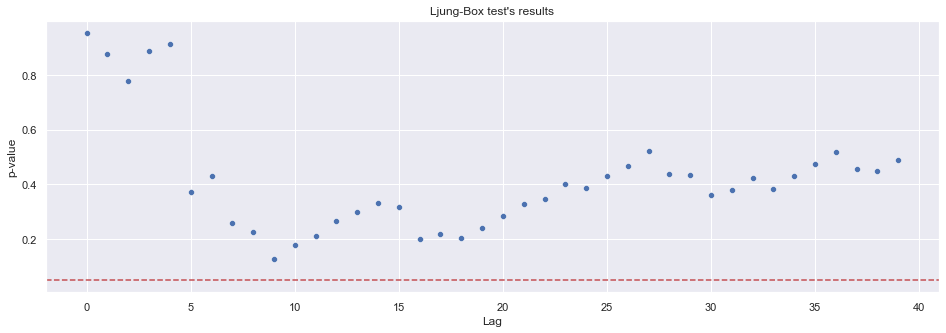

In [14]:
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])),
                y=ljung_box_results[1],
                ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
       xlabel='Lag',
       ylabel='p-value')

Como una extensión se utiliza la función de Auto ARIMA, con el propósito de que el sistema realice la estimación de los rezagos óptimos.

In [15]:
model = pm.auto_arima(returns,
                      error_action='ignore',
                      suppress_warnings=True,
                      seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1674
Model:               SARIMAX(2, 0, 2)   Log Likelihood                2614.586
Date:                Mon, 13 Jun 2022   AIC                          -5219.172
Time:                        10:18:43   BIC                          -5192.057
Sample:                             0   HQIC                         -5209.126
                               - 1674                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1161      0.111      1.048      0.295      -0.101       0.333
ar.L2          0.7418      0.110      6.759      0.000       0.527       0.957
ma.L1         -0.1406      0.121     -1.165      0.244      -0.377       0.096
ma.L2         -0.6808      0.120     -5.676      0.000      -0.916      -0.446
sigma2         0.0026   4.74e-05     54.378      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):              2040.87
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.25
Prob(H) (two-sided):                  0.13   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model = pm.auto_arima(returns,
                      error_action='ignore',
                      suppress_warnings=True,
                      seasonal=False,
                      stepwise=False,
                      approximation=False,
                      n_jobs=-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1674
Model:               SARIMAX(2, 0, 2)   Log Likelihood                2614.586
Date:                Mon, 13 Jun 2022   AIC                          -5219.172
Time:                        10:18:56   BIC                          -5192.057
Sample:                             0   HQIC                         -5209.126
                               - 1674                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1161      0.111      1.048      0.295      -0.101       0.333
ar.L2          0.7418      0.110      6.759      0.000       0.527       0.957
ma.L1         -0.1406      0.121     -1.165      0.244      -0.377       0.096
ma.L2         -0.6808      0.120     -5.676      0.000      -0.916      -0.446
sigma2         0.0026   4.74e-05     54.378      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):              2040.87
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.25
Prob(H) (two-sided):                  0.13   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""